_Lambda School Data Science, Unit 2_
 
# Regression 1 Sprint Challenge

Your Sprint Challenge has two parts.

To demonstrate mastery on each part, do all the required, numbered instructions. 

To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Predict avocado sales 🥑

For part 1 of your challenge, you'll use historical data on avocado sales across the nation!

Run this code cell to load the dataset. It has weekly sales volume (total number of avocados sold) from January 4, 2015 through March 25, 2018. The data comes directly from retailers' cash registers based on actual retail sales of Hass avocados in multiple US markets.

In [0]:
import pandas as pd
avocado_url = 'https://drive.google.com/uc?export=download&id=1ljE-LhCA9CCFvSIJYJ1ewX8JmdDpfuhi'
avocado = pd.read_csv(avocado_url)
assert avocado.shape == (169, 2)

### Required

#### Use the Prophet library to:
1. Fit a model and forecast avocado sales through March 25, 2020
2. Plot the forecast
3. Plot the forecast components
4. Do time series cross-validation, with these parameters: `horizon='90 days', period='45 days', initial='730 days'`
5. Plot the cross-validation Mean Absolute Percentage Error: `metric='mape'`

_For Part 1 of this Sprint Challenge, you are **not** required to calculate or plot baselines, or do train/test split._

You can be confident you've done it correctly when your plots look similar to these:

<img src="https://i.imgur.com/PoyVGp7.png" width="400" align="left">



### Stretch Goal
- Adjust your forecasts with Prophet's options for changepoints, holidays, and fourier order. Improve the cross-validation MAPE.

In [0]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import numpy as np

In [0]:
style.use('ggplot')

In [4]:
avocado.head()

,Date,Total Volume
0,2015-01-04,84674288
1,2015-01-11,78555753
2,2015-01-18,78388735
3,2015-01-25,76466226
4,2015-02-01,119453181


In [5]:
avocado.tail()

,Date,Total Volume
164,2018-02-25,109231389
165,2018-03-04,111844876
166,2018-03-11,111465145
167,2018-03-18,113673928
168,2018-03-25,118268903


In [0]:
avocado['Date'] = pd.to_datetime(avocado['Date'])
avocado = avocado.set_index('Date')

In [7]:
avocado.head()

,Total Volume
Date,
2015-01-04,84674288
2015-01-11,78555753
2015-01-18,78388735
2015-01-25,76466226
2015-02-01,119453181


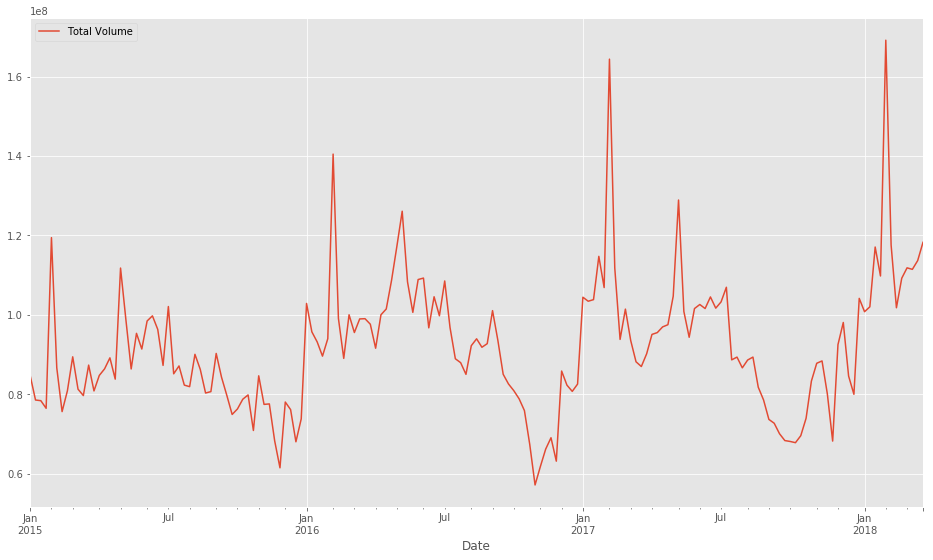

In [8]:
%matplotlib inline
avocado.plot(figsize=(16,9));

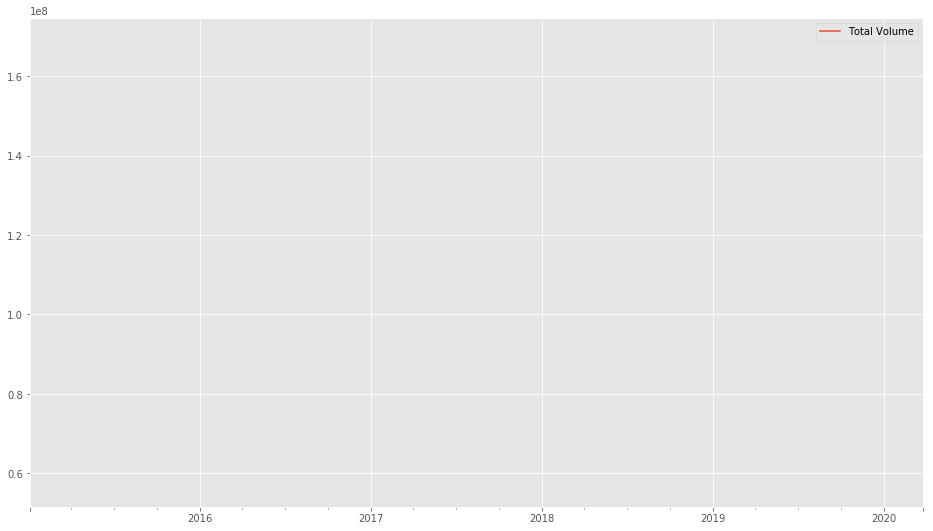

In [9]:
predict = pd.DataFrame(avocado['Total Volume'].copy())
predict = predict.reindex(pd.date_range(start='2015-01-04', end='2020-03-25'))
predict.plot(figsize=(16,9));

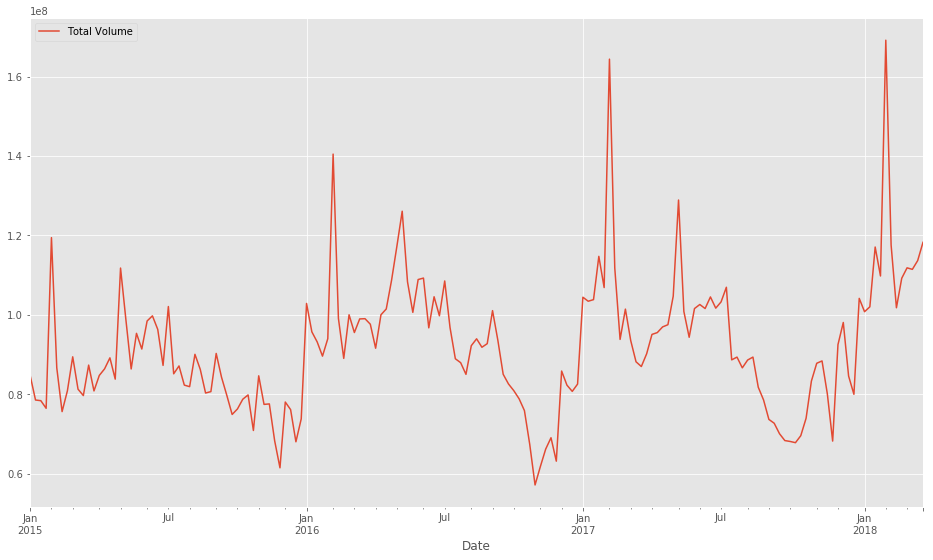

In [10]:
avocado['2015-01-04':'2020-03-25'].plot(figsize=(16,9));

In [0]:
df = avocado.copy().rename(columns={'Date':'ds', 'Total Volume':'y'})

In [12]:
df.head()

,y
Date,
2015-01-04,84674288
2015-01-11,78555753
2015-01-18,78388735
2015-01-25,76466226
2015-02-01,119453181


In [13]:
df.tail()

,y
Date,
2018-02-25,109231389
2018-03-04,111844876
2018-03-11,111465145
2018-03-18,113673928
2018-03-25,118268903


In [0]:
df = df.reindex(pd.date_range(start='2015-01-04', end='2018-03-26'))
#df.head(100)

In [0]:
#avocado.head(100)

In [16]:
df = df.reset_index().rename(columns={'index': 'ds', 'Total Volume': 'y'})
from fbprophet import Prophet
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
future = m.make_future_dataframe(periods=365*2)
future.tail()

,ds
1903,2020-03-21
1904,2020-03-22
1905,2020-03-23
1906,2020-03-24
1907,2020-03-25


In [18]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1903,2020-03-21,1.074891e+08,1.024184e+08,1.275191e+08,1.056116e+08,1.094523e+08,8.209257e+06,8.209257e+06,8.209257e+06,8.209257e+06,8.209257e+06,8.209257e+06,0.0,0.0,0.0,1.156984e+08
1904,2020-03-22,1.075012e+08,1.030729e+08,1.284513e+08,1.056163e+08,1.094681e+08,7.849158e+06,7.849158e+06,7.849158e+06,7.849158e+06,7.849158e+06,7.849158e+06,0.0,0.0,0.0,1.153503e+08
1905,2020-03-23,1.075132e+08,1.012245e+08,1.276602e+08,1.056234e+08,1.094845e+08,7.370433e+06,7.370433e+06,7.370433e+06,7.370433e+06,7.370433e+06,7.370433e+06,0.0,0.0,0.0,1.148836e+08
1906,2020-03-24,1.075252e+08,1.013767e+08,1.274514e+08,1.056338e+08,1.095027e+08,6.786255e+06,6.786255e+06,6.786255e+06,6.786255e+06,6.786255e+06,6.786255e+06,0.0,0.0,0.0,1.143115e+08
1907,2020-03-25,1.075373e+08,1.009121e+08,1.262588e+08,1.056437e+08,1.095202e+08,6.112747e+06,6.112747e+06,6.112747e+06,6.112747e+06,6.112747e+06,6.112747e+06,0.0,0.0,0.0,1.136500e+08


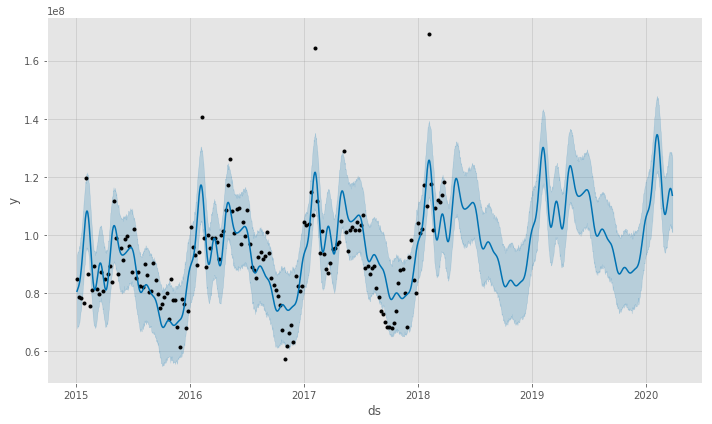

In [19]:
fig1 = m.plot(forecast)

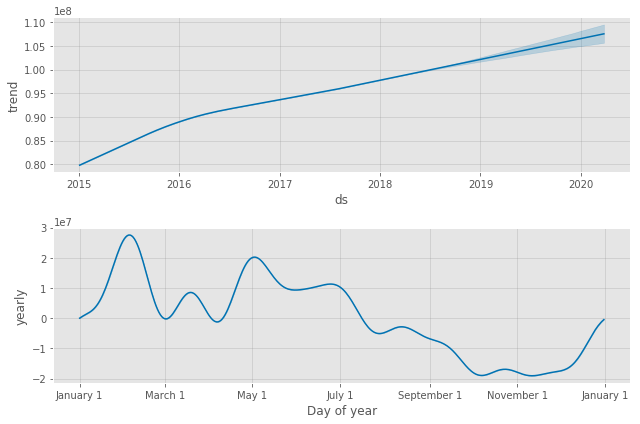

In [20]:
fig2 = m.plot_components(forecast)

In [23]:
#this is the code that should produce the cross validation matrix with specified parameteres
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(df, initial='730 days', 
                         horizon='90 days', period='45 days')

AttributeError: ignored

In [25]:
#because I was not ablt to resolve the attribute 'history' value above I could not 
#plot the cross validation shape and appropriate metric
# as the data frame (df_cv) does not exist
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

NameError: ignored

## Part 2. Predict NYC apartment rent 🏠💸

For part 1 of your challenge, you'll use a real-world data with rent prices for a subset of apartments in New York City!

Run this code cell to load the dataset: 

In [0]:
import pandas as pd
rent_url = 'https://drive.google.com/uc?export=download&id=1lVVPmh-WYGb_0Gs_lOv22i02-150qDdZ'
rent = pd.read_csv(rent_url)
assert rent.shape == (48295, 7)

### Required
1. Begin with baselines for regression. Calculate the mean absolute error and $R^2$ score for a mean baseline. _(You can use the whole dataset, or a test set, either way is okay here!)_
2. Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
3. Choose any two features.
4. Use scikit-learn to fit a Linear Regression model on the train data.
5. Apply the model to predict rent prices for the test data.
6. Get regression metrics MAE and $R^2$ for the test data.
7. Get the model's coefficients and intercept.

### Stretch Goals
- Try at least 3 different feature combinations. (You don't have to use two features, you can choose any number of features.)
- Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.

In [27]:
rent.head()

,year,month,bedrooms,bathrooms,latitude,longitude,price
0,2016,6,3,1.5,40.7145,-73.9425,3000
1,2016,6,2,1.0,40.7947,-73.9667,5465
2,2016,4,1,1.0,40.7388,-74.0018,2850
3,2016,4,1,1.0,40.7539,-73.9677,3275
4,2016,4,4,1.0,40.8241,-73.9493,3350


In [45]:
target = 'price'

mean_baseline = pd.DataFrame([rent[target].mean()] * len(df))

mean_baseline.iloc[0]

0    3438.052034
Name: 0, dtype: float64

In [0]:
rent['Mean Baseline'] = mean_baseline

In [42]:
rent.head()

,year,month,bedrooms,bathrooms,latitude,longitude,price,Mean Baseline
0,2016,6,3,1.5,40.7145,-73.9425,3000,3438.052034
1,2016,6,2,1.0,40.7947,-73.9667,5465,3438.052034
2,2016,4,1,1.0,40.7388,-74.0018,2850,3438.052034
3,2016,4,1,1.0,40.7539,-73.9677,3275,3438.052034
4,2016,4,4,1.0,40.8241,-73.9493,3350,3438.052034


In [46]:
rent['Error'] = df['Mean Baseline'] - rent[target]
rent.head()

,year,month,bedrooms,bathrooms,latitude,longitude,price,Mean Baseline,Error
0,2016,6,3,1.5,40.7145,-73.9425,3000,3438.052034,438.052034
1,2016,6,2,1.0,40.7947,-73.9667,5465,3438.052034,-2026.947966
2,2016,4,1,1.0,40.7388,-74.0018,2850,3438.052034,588.052034
3,2016,4,1,1.0,40.7539,-73.9677,3275,3438.052034,163.052034
4,2016,4,4,1.0,40.8241,-73.9493,3350,3438.052034,88.052034


In [0]:
rent['Absolute Error'] = rent['Error'].abs()

In [52]:
rent.head()

,year,month,bedrooms,bathrooms,latitude,longitude,price,Mean Baseline,Error,Absolute Error
0,2016,6,3,1.5,40.7145,-73.9425,3000,3438.052034,438.052034,438.052034
1,2016,6,2,1.0,40.7947,-73.9667,5465,3438.052034,-2026.947966,2026.947966
2,2016,4,1,1.0,40.7388,-74.0018,2850,3438.052034,588.052034,588.052034
3,2016,4,1,1.0,40.7539,-73.9677,3275,3438.052034,163.052034,163.052034
4,2016,4,4,1.0,40.8241,-73.9493,3350,3438.052034,88.052034,88.052034


In [51]:
rent['Absolute Error'].mean() 

1035.2504470174893

In [53]:
rent.shape

(48295, 10)

In [54]:
len(rent)

48295

In [0]:
x = rent['bedrooms']
y = rent['price']

m = 0
b = y.mean()
y_pred = m*x + b

Mean Absolute Error: 1055.7857771080928
R^2: 0.0


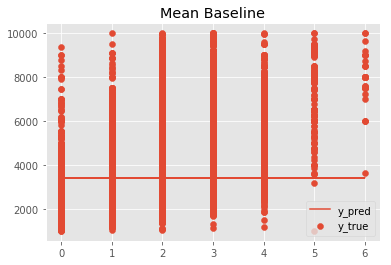

In [63]:
from sklearn.metrics import mean_absolute_error, r2_score

def plot_preds(x, y, y_pred):
    plt.scatter(x, y, label='y_true')
    plt.plot(x, y_pred, label='y_pred')
    plt.legend()
    
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)
    
plot_preds(x, y, y_pred)
plt.title('Mean Baseline');

In [67]:
rent.head()

,year,month,bedrooms,bathrooms,latitude,longitude,price,Mean Baseline,Error,Absolute Error
0,2016,6,3,1.5,40.7145,-73.9425,3000,3438.052034,438.052034,438.052034
1,2016,6,2,1.0,40.7947,-73.9667,5465,3438.052034,-2026.947966,2026.947966
2,2016,4,1,1.0,40.7388,-74.0018,2850,3438.052034,588.052034,588.052034
3,2016,4,1,1.0,40.7539,-73.9677,3275,3438.052034,163.052034,163.052034
4,2016,4,4,1.0,40.8241,-73.9493,3350,3438.052034,88.052034,88.052034


In [70]:
rent.month.unique()

array([6, 4, 5])

In [0]:
features = ['bedrooms', 'bathrooms']
target = 'price'

In [73]:
train = rent.query('month < 6')
test  = rent.query('month >= 6')
X_train = train[features] 
y_train = train[target]
X_test  = test[features]
y_test  = test[target]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31512, 2), (31512,), (16783, 2), (16783,))

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
model = LinearRegression()

In [77]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [78]:
y_pred = model.predict(X_test)

y_pred

array([4553.47941921, 3367.08837864, 2946.57866184, ..., 2946.57866184,
       3367.08837864, 3367.08837864])

In [80]:
mean_absolute_error(y_test, y_pred) #Less than the previous mean baseline which would suggest model is working

754.0733041489015

In [82]:
r2_score(y_test, y_pred)

0.4613584851907725

In [83]:
model.intercept_, model.coef_,

(994.3062975058142, array([ 420.5097168 , 1531.76264753]))